In [372]:
import arrow as A
import scipy
from PIL import Image
import torch
import torchmetrics
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import itertools
import torchvision
import xarray as xr
import seaborn as sb

In [512]:
torch.cuda.empty_cache()
print(f'( {torch.cuda.device_count()} ) {torch.cuda.get_device_name(0)} available')

( 1 ) NVIDIA GeForce GTX 1080 Ti available


In [515]:
def write(x,y):
    with open(x,'a') as f:
        f.write(y)
        f.write('\n')
        f.close()
    return _
def xarr2torch(x):
        return torch.from_numpy(np.asarray(x)).unsqueeze(0).unsqueeze(0).float()

def unfold_fold(arr,kernel_size,patch_selector=5):
   
    #input array should be 4-dim, typically [1,1,x,y]
    #kern should be the same
    # print(arr.shape)
    unfold = torch.nn.Unfold(kernel_size=(kernel_size,kernel_size),stride=(kernel_size,kernel_size))
    m_unfold0 = unfold(arr)
    # print(m_unfold0.shape)
    m_unfold1 = m_unfold0.permute(2,0,1)
    # print(m_unfold1.shape)
    m_unfold2 = m_unfold1.reshape(-1,1,kernel_size,kernel_size)
    # print(m_unfold2.shape)
    # m_unfold_means = torch.FloatTensor([torch.nanmean(i) for i in m_unfold]) 
    
    m_unfold3 = torch.full((1,1,m_unfold2.shape[2],m_unfold2.shape[3]),torch.nan)
    
    ok = torch.empty((0,1,m_unfold2.shape[2],m_unfold2.shape[3]))
    for idx,i in enumerate(m_unfold2):
        if idx == patch_selector:
            ok = torch.cat((ok,i.unsqueeze(0)))
        else:
            ok = torch.cat((ok,m_unfold3))
    print(f'{ok.shape}')
        
    
    
    folding = ok.reshape(m_unfold1.shape)
    print(folding.shape)
    folding = folding.permute(1,2,0)
    print(folding.shape)
    fold = torch.nn.Fold(output_size=(arr.shape[2],arr.shape[3]),kernel_size=(kernel_size,kernel_size),stride=(kernel_size,kernel_size))
    m_fold = fold(folding)

    #outputs 2d array
   
    return m_fold,patch_selector

def fill_NOwhiten(x):
    a1 = torch.nanmean(x)
    # b1 = np.nanstd(x)
    y = torch.where(torch.isfinite(x)==False,a1,x)
    # y = (y-a1)/b1
    return y,a1

class Lnet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # in layer
        flow_channels = 128
        self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=flow_channels, kernel_size=3, padding=1, bias=False)
        self.relu1 = torch.nn.ReLU(inplace=True)
        # hidden layers
        hidden_layers = []
        for i in range(15):
            hidden_layers.append(torch.nn.Conv2d(in_channels=flow_channels, out_channels=flow_channels, kernel_size=3, padding=1, bias=False))
            hidden_layers.append(torch.nn.BatchNorm2d(flow_channels))
            hidden_layers.append(torch.nn.ReLU(inplace=True))
        self.mid_layer = torch.nn.Sequential(*hidden_layers)
        # out layer
        self.conv3 = torch.nn.Conv2d(in_channels=flow_channels, out_channels=1, kernel_size=3, padding=1, bias=False)

    def forward(self, x):
        out1 = self.relu1(self.conv1(x))
        out = self.mid_layer(out1)
        out = self.conv3(out+out1)
        return out
    
class dset_maker(torch.utils.data.Dataset):
    def __init__(self,x,y,patch_select):
        self.x = torch.load(x)[:,patch_select].reshape(-1,1,100,100)
        self.y = torch.load(y)[:,patch_select].reshape(-1,1,100,100)
        self.x,self.mean = fill_NOwhiten(self.x)
        self.y,_ = fill_NOwhiten(self.y)
    
#         rand_pts = torch.from_numpy(np.random.randint(0,self.x.shape[0],100))
        
#         self.x = self.x[rand_pts]
#         self.y = self.y[rand_pts]
        
#         self.combo = torch.cat((self.x.unsqueeze(0),self.y.unsqueeze(0)),0)
        
#         RVF = torchvision.transforms.RandomVerticalFlip()
#         RHF = torchvision.transforms.RandomHorizontalFlip()
        
#         self.combo_transformed = RVF(RHF(self.combo))
#         self.x = self.combo_transformed[0]
#         self.y = self.combo_transformed[1]
        
    def __getitem__(self,idx):
        x = self.x[idx].to('cuda')
#         x -= torch.min(x)
#         x /= torch.max(x)
        y = self.y[idx].to('cuda')
#         y -= torch.min(y)
#         y /= torch.max(y)

        return x, y
    def __len__(self):
#         print(self.x.shape[0])
        return self.x.shape[0]

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight.data,0.0,0.02)
    elif classname.find('BatchNorm') != -1:
        torch.nn.init.normal_(m.weight.data,1.0,0.02)
        torch.nn.init.constant_(m.bias.data,0)  
        
def train(epoch):
    epoch_loss = 0
    c=0
    for x,y in train_dataloader:
        c+=1

        # target = y-x
        predicted = model(x)

        loss = criterion(predicted, y)
        epoch_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
    write('../zultz/case5_onepatch_trn.txt',f'Epoch {epoch} Train Mean MSE: {np.around(epoch_loss/len(train_dataloader),3)}')
    
def validate():
    # validate.avg_psnr = 0
    # avg_psnr = 0
    model.eval()
    with torch.no_grad():
        t_loss = 0
        for xx,yy in valid_dataloader:
            # target = yy-xx
            predicted = model(xx)
            mse = criterion(predicted, yy)
            t_loss += mse.item()
            # modis = yy.cpu().numpy().squeeze().squeeze();
            # amsre = xx.cpu().numpy().squeeze();
            # adj = predicted.cpu().numpy().squeeze();
            # # psnr = 10 * np.log10(np.power(np.max(modis),2) / mean_squared_error(modis,amsre+adj))
            # validate.avg_psnr += (psnr / len(valid_dataloader))
        
    write('../zultz/case5_onepatch_val.txt',f'Epoch {epoch} Valid Mean MSE: {np.around(t_loss/len(valid_dataloader),3)}')
    

class small_dset_creator(torch.utils.data.Dataset):
    def __init__(self,x,y,patch_select):
        self.wx = torch.load(x)
        self.x = torch.load(x)[-1,patch_select].reshape(-1,1,100,100)
        self.x0 = torch.clone(self.x)
        self.y = torch.load(y)[-1,patch_select].reshape(-1,1,100,100)
        self.y0 = torch.clone(self.y)
        self.x,self.mean = fill_NOwhiten(self.x)
        self.y,_ = fill_NOwhiten(self.y)
        
    def __getitem__(self,idx):
        x = self.x[idx].to('cuda')
        y = self.y[idx].to('cuda')
        x0 = self.x0[idx]
        y0 = self.y0[idx]
        mean = self.mean
        return x,y
    def __len__(self):
        return self.x.shape[0]

def conf99(x):
    mu = np.nanmean(x)
    sig = np.nanstd(x)
    return mu + (3*sig)

def mse(x,y):
    e = y-x
    se = e**2
    
    valcount = torch.where(torch.isnan(se)==False,1,0)
    valcount = torch.sum(valcount)

    sse = np.nansum(se)
    mse = np.nanmean(sse)
    return mse, valcount

def rmse(x,y):
    e = y-x
    se = e**2
    
    valcount = torch.where(torch.isnan(se)==False,1,0)
    valcount = torch.sum(valcount)

    sse = np.nansum(se)
    mse = np.nanmean(sse)
    rmse = np.sqrt(mse)
    return rmse, valcount
        

torch.Size([18, 1, 100, 100])
torch.Size([18, 1, 10000])
torch.Size([1, 10000, 18])


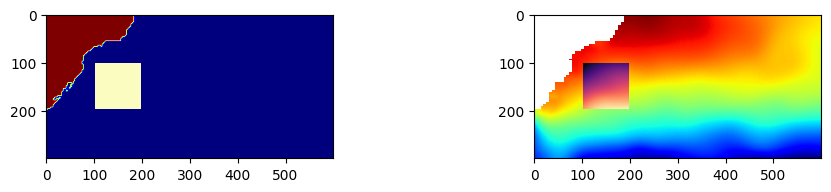

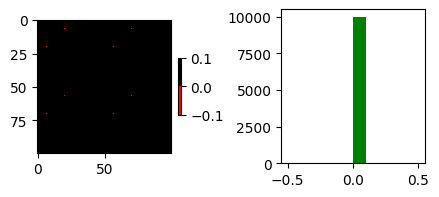

training occurring on: cuda
training began at: 2022-12-15T16:01:12.476946-05:00
trained completed at: 2022-12-15T16:02:11.499088-05:00


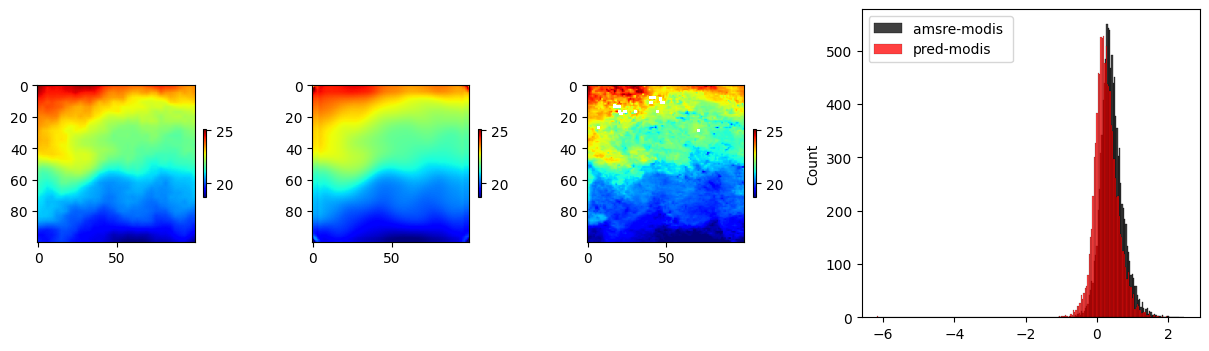

dif between variable and argo
argo		(0.0, tensor(10000))
amsre		(35.71962, tensor(10000))
modis		(79.61491, tensor(9980))
pred		(48.745476, tensor(10000))
optim		(48.745476, tensor(10000))


dif between variable and modis
argo		(79.61491, tensor(9980))
amsre		(53.402195, tensor(9980))
modis		(0.0, tensor(9980))
pred		(43.96603, tensor(9980))
optim		(43.96603, tensor(9980))


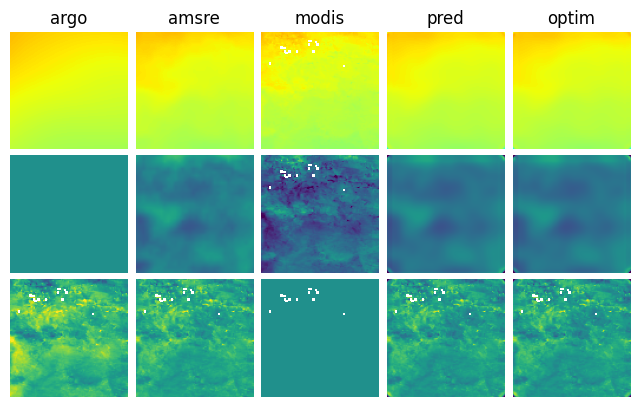

In [517]:
patchsize=100
num_epochs = 500
lr = 1e-5
viewheight = 300
viewwidth = 600
latup = 1300
latdown = latup + viewheight
lonleft = 1500
lonright = lonleft + viewwidth
patch_selector = 7


land_mask = xr.open_dataset('../../data/land_mask.nc')
land_mask = land_mask.GLDAS_mask[0][latup:latdown,lonleft:lonright]
land_mask = xarr2torch(land_mask)

argo = torch.load('../../data/patches/case_5_argo_2010_atlantic_night.pt')
argo1 = argo[-1]
argo2 = argo1.reshape(-1,1,argo1.shape[2] * argo1.shape[3]).permute(1,2,0)
fold = torch.nn.Fold(output_size=(land_mask.shape[2],land_mask.shape[3]),kernel_size=(patchsize,patchsize),stride=(patchsize,patchsize))
argofold = fold(argo2)

single_patch_mask,patch_selector = unfold_fold(land_mask,100,patch_selector=patch_selector)
fig = plt.figure(figsize=(10,6))
gs = gridspec.GridSpec(1,2,wspace=.7)

fig.add_subplot(gs[0,0])
plt.gca().set_aspect('equal')
plt.imshow(land_mask[0,0],cmap='jet')
plt.imshow(np.where(single_patch_mask[0,0]==0,land_mask[0,0],np.nan),cmap='magma_r')

fig.add_subplot(gs[0,1])
plt.gca().set_aspect('equal')
plt.imshow(argofold[0,0],cmap='jet')
plt.imshow(np.where(single_patch_mask[0,0]==0,argofold[0,0],np.nan),cmap='magma_r')
plt.pause(0.05)

unfoldobj = torch.nn.Unfold(kernel_size = (patchsize,patchsize),stride=int((patchsize/1)))
mask_patches = unfoldobj(land_mask).permute(2,0,1).reshape(-1,1,patchsize,patchsize)
mask_patches.shape


fig = plt.figure(figsize=(5,2))
gs = gridspec.GridSpec(1,2,wspace=.7)

fig.add_subplot(gs[0,0])
plt.gca().set_aspect('equal')
plt.imshow(mask_patches[patch_selector,0],cmap=blackRed)
plt.colorbar(fraction=.02)

fig.add_subplot(gs[0,1])
plt.gca().set_aspect('auto')
plt.hist(np.asarray(mask_patches[5,0]).reshape(-1),color='green');
plt.pause(0.05)

dset = dset_maker('../../data/patches/case_5_amsre_2010_atlantic_night.pt',
                  '../../data/patches/case_5_modis_2010_atlantic_night.pt',
                 patch_select=patch_selector)

train_size = int(0.80*len(dset))
valid_size = int(0.5*(len(dset) - train_size))
test_size = int(len(dset)-train_size-valid_size)
train_dset, valid_dset, test_dset = torch.utils.data.random_split(dset,[train_size,valid_size,test_size])

train_dataloader = torch.utils.data.DataLoader(dataset=train_dset, batch_size=2, shuffle=False, num_workers=0)
valid_dataloader = torch.utils.data.DataLoader(dataset=valid_dset, batch_size=1, shuffle=False, num_workers=0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'training occurring on: {device}')
model = Lnet().to(device)
model.apply(weights_init)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

t0 = A.now('US/Eastern')
print(f'training began at: {t0}')
write('../zultz/case5_onepatch_trn.txt',str(t0))

   

for epoch in range(1, num_epochs + 1):
    if epoch == 1:
        validate()
    train(epoch)
    if epoch % 10 == 0:
        validate()
t1 = A.now('US/Eastern')
print(f'trained completed at: {t1}')
write('../zultz/case5_onepatch_trn.txt',str(t1));

ds = small_dset_creator('../../data/patches/case_5_amsre_2010_atlantic_night.pt',
                  '../../data/patches/case_5_modis_2010_atlantic_night.pt',
                       patch_select=patch_selector)
    
dl = torch.utils.data.DataLoader(ds,shuffle=False)

model.eval()
pred = []
with torch.no_grad():
    for idx,(x,y) in enumerate(dl):
        # target = y-x
        predicted = model(x)
        predicted = predicted.to('cpu')[0,0]

        predicted = np.where(mask_patches[patch_selector,0]>=.5, np.nan,predicted)
        pred.append(predicted)
        # mse = criterion(predicted,target)
        # test_loss += item()


    
fr = .02
fig = plt.figure(figsize=(15,4))
gs = gridspec.GridSpec(1,4,wspace=.5,width_ratios = (.2,.2,.2,.4))

vmin = np.nanmin(ds.x0[0,0])
vmax = np.nanmax(ds.x0[0,0])

fig.add_subplot(gs[0,0])
plt.imshow(ds.x0[0,0],vmin=vmin,vmax=vmax,cmap='jet')
# plt.colorbar(fraction=.02
plt.colorbar(fraction=fr)

fig.add_subplot(gs[0,1])
plt.imshow(pred[0],vmin=vmin,vmax=vmax,cmap='jet')
plt.colorbar(fraction=fr)

fig.add_subplot(gs[0,2])
plt.imshow(ds.y0[0,0],vmin=vmin,vmax=vmax,cmap='jet')
plt.colorbar(fraction=fr)


fig.add_subplot(gs[0,3])
hist = ds.x0[0,0] - ds.y0[0,0]
hist = np.asarray(hist).reshape(-1)
hist1 = pred[0] - np.asarray(ds.y0[0,0])
hist1 = np.asarray(hist1).reshape(-1)
histplot = sb.histplot(hist,color='black');
hist1plot = sb.histplot(hist1,color='red');
plt.legend(['amsre-modis ','pred-modis'],loc='upper left')



plt.pause(0.05)
    # break
    # hist1.shape
    
hei = 3
wid = 5

fig = plt.figure(figsize=(8,4.8))
# plt.title(f'{date}_{satnames[idx]}_{oc}_{satt}')
plt.axis('off')
gs = gridspec.GridSpec(hei,
                       wid,
                       hspace=.01,
                       wspace=.07,
                       width_ratios=list(itertools.repeat(.1,wid)),
                       height_ratios=list(itertools.repeat(.1,hei))
                       )
filter_coast = torch.from_numpy(np.where(np.abs(pred[0]) > np.abs(conf99(pred[0])),np.nan,pred[0]))

x0 = argo[-1][patch_selector,0] #argo
x1 = ds.x0[0,0] #amsre
x2 = ds.y0[0,0] #modis
x3 = pred[0] #pred 
x4 = filter_coast #filtered pred


xs = [x0,x1,x2,x3,x4]
nms = ['argo','amsre','modis','pred','optim']

for idx,i in enumerate(xs):
    fig.add_subplot(gs[0,idx])
    plt.imshow(i,cmap='jet',vmin=0,vmax=35)
    plt.title(nms[idx])
    plt.axis('off')
    
    fig.add_subplot(gs[1,idx])
    plt.imshow(i-np.asarray(x0),vmin=-2,vmax=2) #compare to argo
    plt.axis('off')
    
    fig.add_subplot(gs[2,idx])
    plt.imshow(i-np.asarray(x2),vmin=-2,vmax=2)
    plt.axis('off')

print(f'dif between variable and argo')
for idx,i in enumerate(xs):
    print(f'{nms[idx]}\t\t{rmse(i,x0)}')

print('\n')

print(f'dif between variable and modis')
for idx,i in enumerate(xs):
    print(f'{nms[idx]}\t\t{rmse(i,x2)}')